# **NVIDIA Stock Price Analysis**
## **Objective:**
- The primary objective of this project is to further my understanding of NVIDIA as a company and a stock market investment. This can be done using the following:
- Use Deep Learning & Neural Networks (application of research).
- Perform an EDA on NVIDIA's stock price, and relate this to the real world. This could involve:
    - Trend Analysis
    - Volatility Analysis
    - Earnings Reports
    - Balance Sheet Health
    - Sector Trends
    - Competitive Position
    - Sentiment of Other Investors
- Perform a predictive analysis on NVIDIA's stock price.
    - Using RNNs and LSTMs
- Perform the analysis above with reference to NVIDIA's competitors
    - Namely, AMD, Intel and QualComm
    

### Installations:

In [2]:
%pip install pandas
%pip install yfinance


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports:

In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 

In [4]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

### Data Retreival & Cleaning:

In [5]:
# Retrieve 5 Years of NVIDIA's Stock Data
stocks = ['NVDA', 'AMD', 'INTC', 'QCOM']
data_list = []

now = datetime.now()

for stock in stocks:
    df = yf.download(stock, now - relativedelta(years=5), now)
    df['Stock'] = stock
    data_list.append(df)

c_names = ["NVIDIA", "AMD", "INTEL", "QUALCOMM"]
colors = {
    "NVIDIA": "green",
    "INTEL": "#6fa8dc", 
    "AMD": "red",
    "QUALCOMM": "darkblue" 
}

for c_data, c_name in zip(data_list, c_names):
    c_data['Company Name'] = c_name

data = pd.concat(data_list, axis = 0)

# Descriptive Statistics & Information
print(data.describe())
print(data.info())

# Data Cleaning

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
              Open         High          Low        Close    Adj Close  \
count  5032.000000  5032.000000  5032.000000  5032.000000  5032.000000   
mean    109.030376   110.888857   107.162189   109.100051   106.721832   
std      90.250481    91.811683    88.657120    90.381418    90.785936   
min      21.350000    22.090000    21.040001    22.010000    22.010000   
25%      51.687501    52.317500    51.090000    51.740002    47.907252   
50%      85.547501    87.089996    84.125000    85.545002    82.599998   
75%     133.513752   135.402500   131.597496   133.500000   129.968700   
max     726.000000   746.109985   712.500000   722.479980   722.479980   

             Volume  
count  5.032000e+03  
mean   3.8632

### EDA of Stock Price

#### Data Visualisation

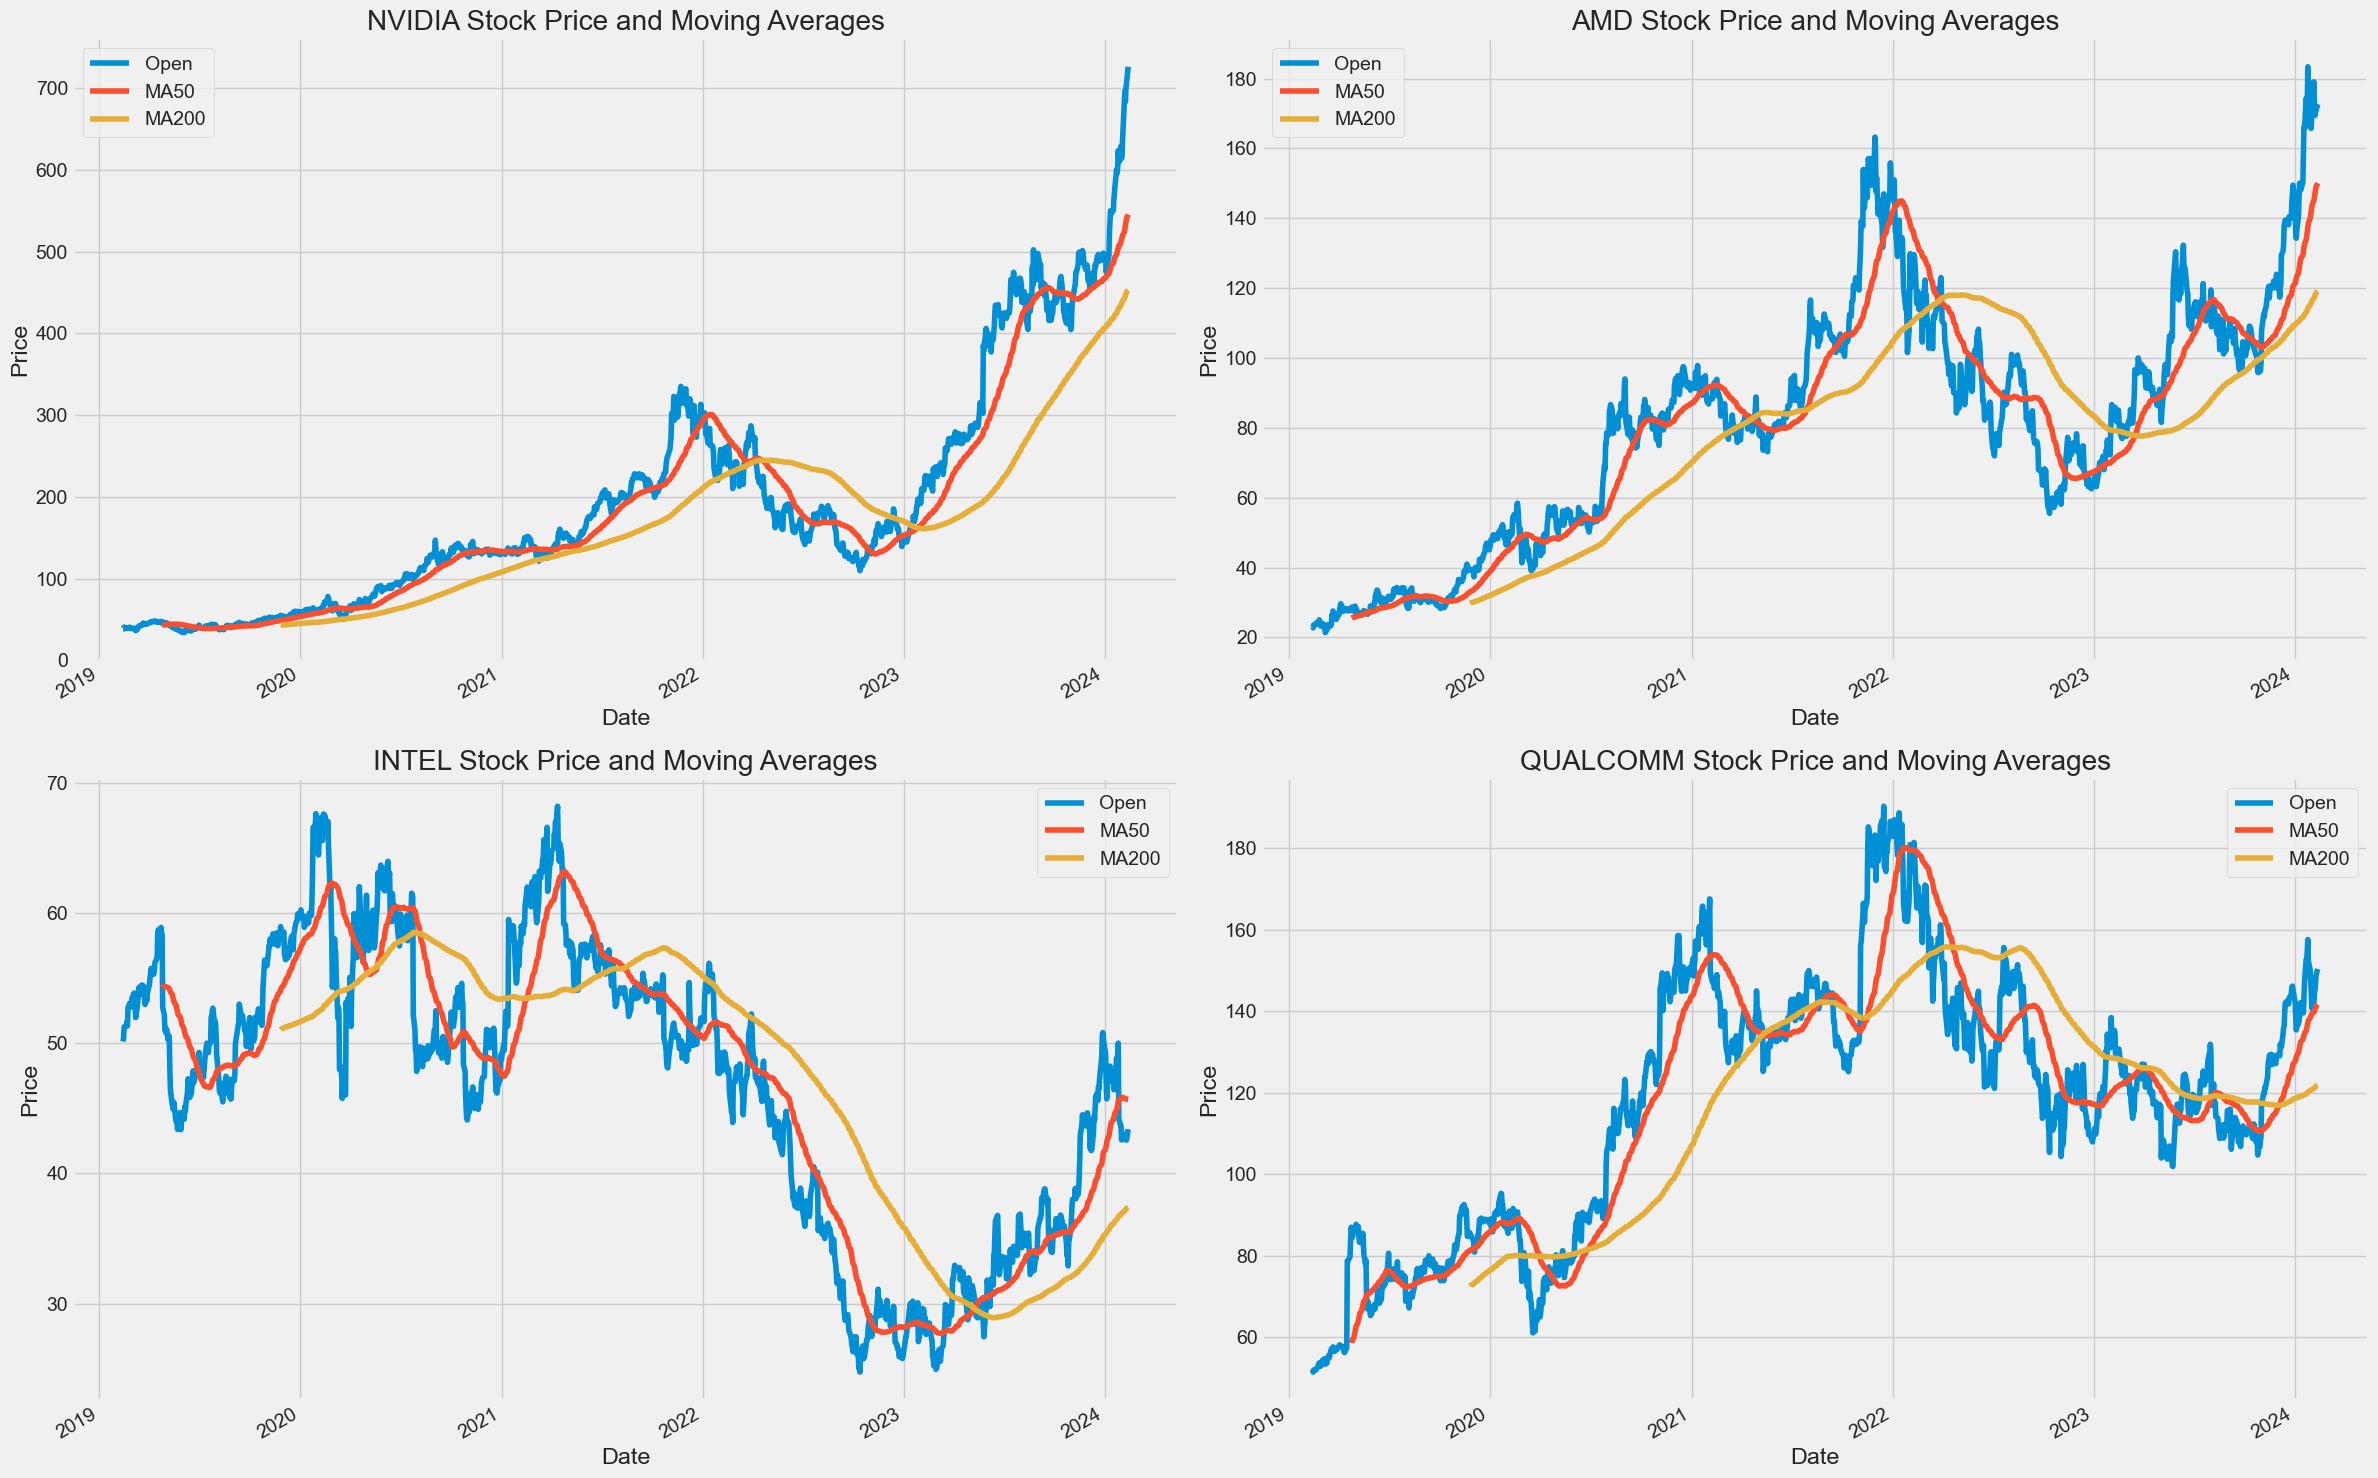

In [6]:
# Set up the matplotlib figure and axes for a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

for i, (c_data, c_name) in enumerate(zip(data_list, c_names)):
    c_data['MA50'] = c_data['Open'].rolling(50).mean()
    c_data['MA200'] = c_data['Open'].rolling(200).mean()
    
    # Direct Pandas plot to use a specific Matplotlib subplot
    c_data[['Open', 'MA50', 'MA200']].plot(ax=axs[i], figsize=(24, 15), title=f"{c_name} Stock Price and Moving Averages")
    
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price')
    axs[i].legend(["Open", "MA50", "MA200"])

plt.tight_layout()
plt.show()

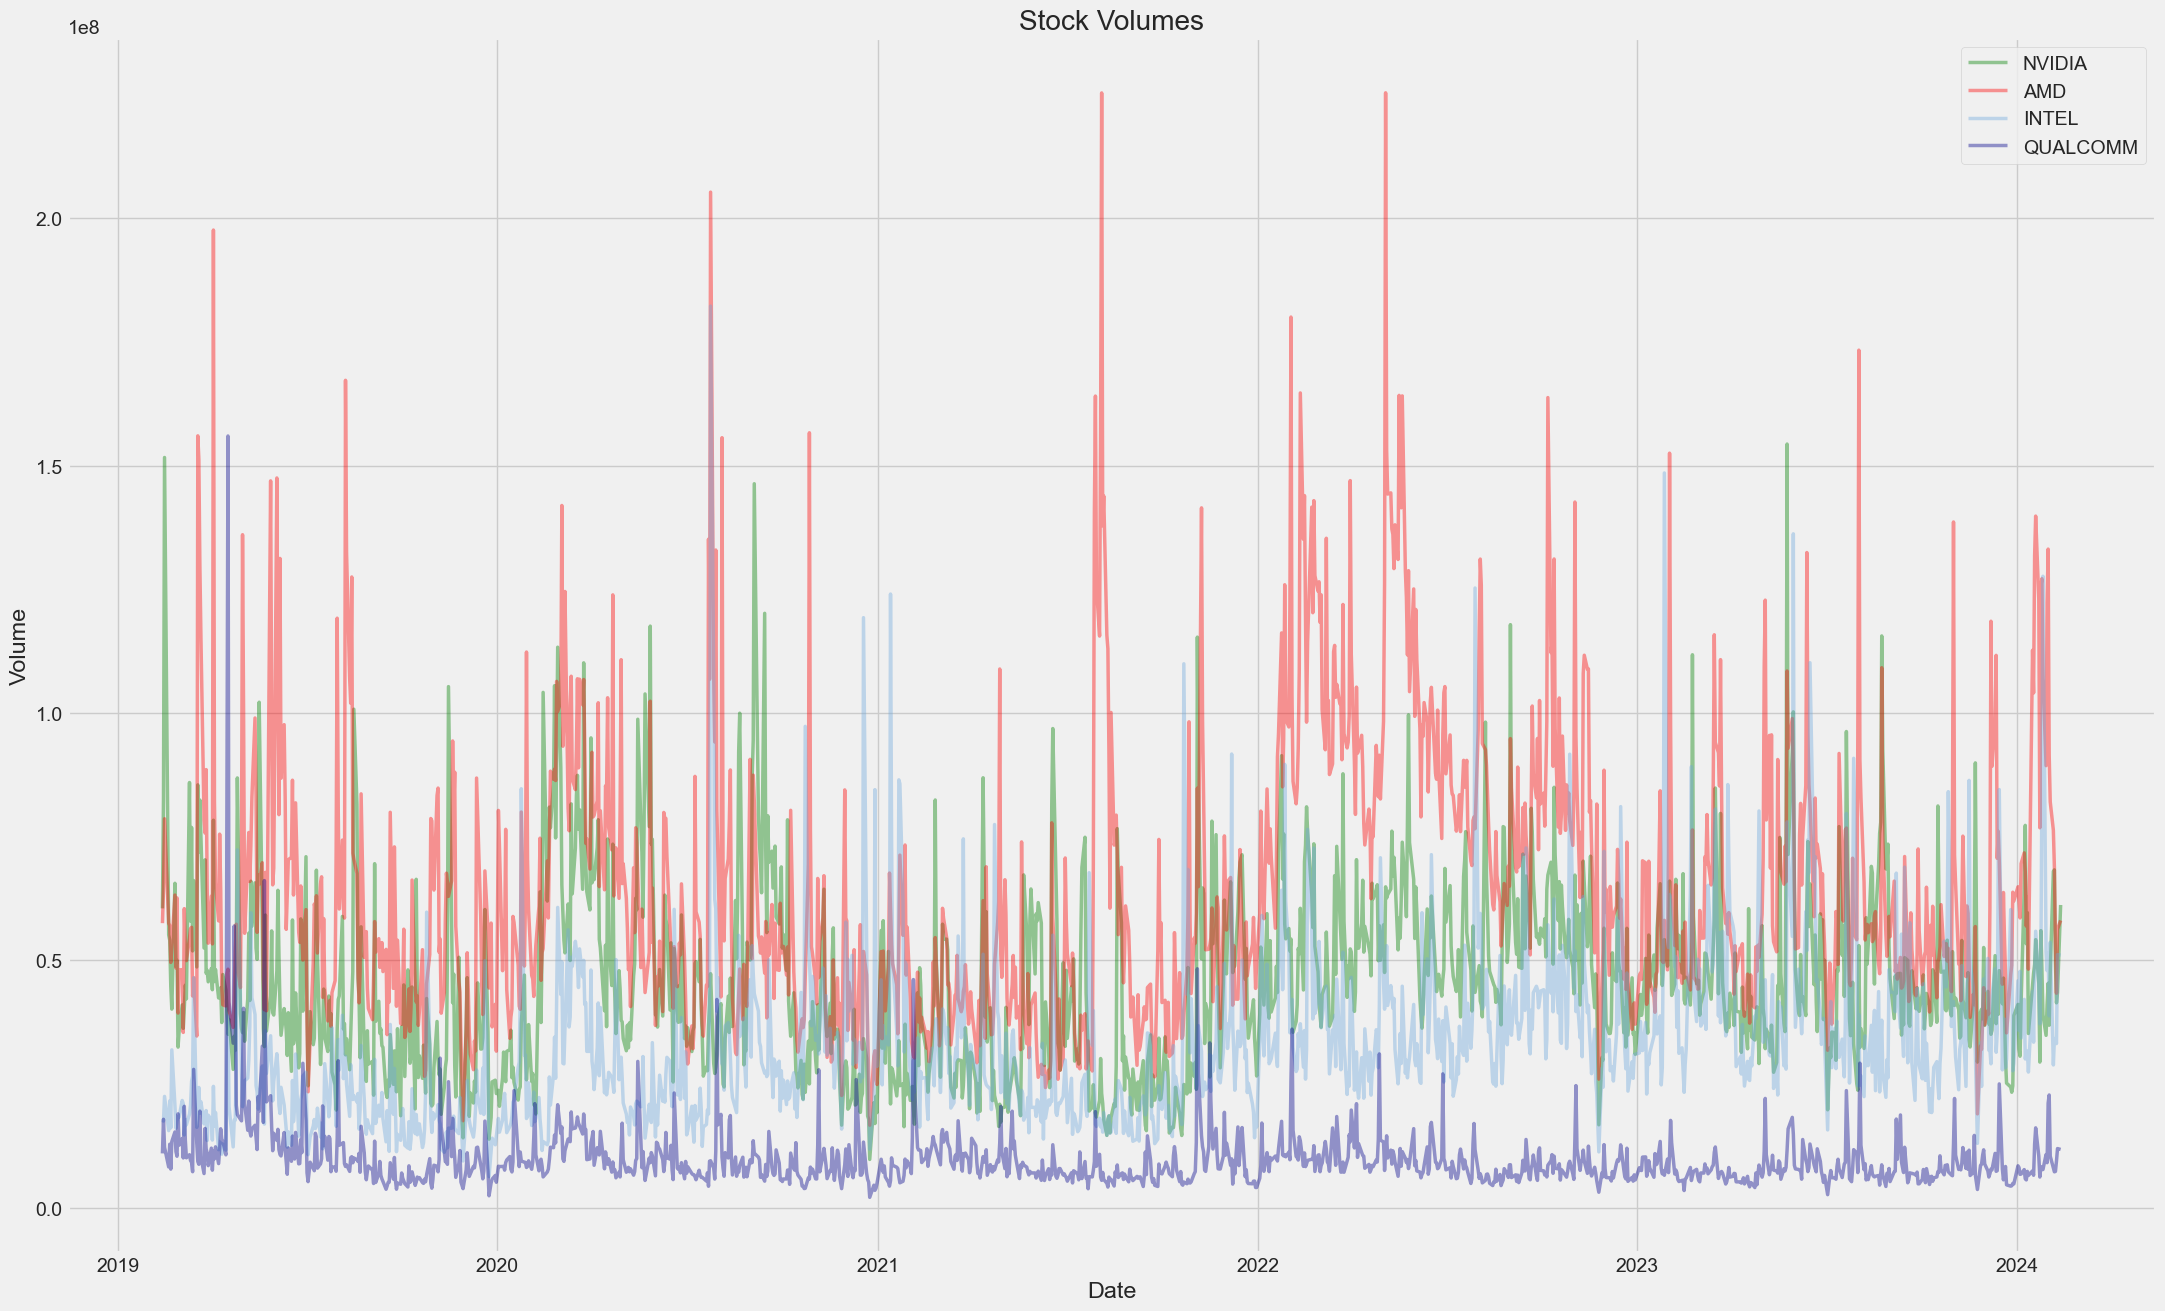

In [7]:
# Set the figure size and title
plt.figure(figsize=(24, 15))
plt.title("Stock Volumes")

# Filter and plot volume for each company
for c_name in c_names:
    # Filter the data for the current company
    company_data = data[data['Company Name'] == c_name]
    
    # Plot the volume data
    plt.plot(company_data.index, company_data['Volume'], label=c_name, color=colors[c_name], alpha=0.4, linewidth=2.5)

plt.legend(loc="best")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

#### Annual Growth Rate

In [10]:
# Calculating Compound Annual Growth Rate
cagr_results = {}
n_years = 5  # The period over which we're calculating CAGR

for c_data, c_name in zip(data_list, c_names):
    # Extract the closing price at the beginning and end of the period
    beginning_value = c_data['Adj Close'].iloc[0]
    ending_value = c_data['Adj Close'].iloc[-1]
    
    # Calculate CAGR
    cagr = ((ending_value / beginning_value) ** (1 / n_years)) - 1
    cagr_results[c_name] = cagr

# Print the CAGR for each company
for company, cagr in cagr_results.items():
    print(f"{company}: {cagr*100:.2f}% annual growth rate")

NVIDIA: 80.30% annual growth rate
AMD: 49.72% annual growth rate
INTEL: -0.06% annual growth rate
QUALCOMM: 27.52% annual growth rate


#### Correlation

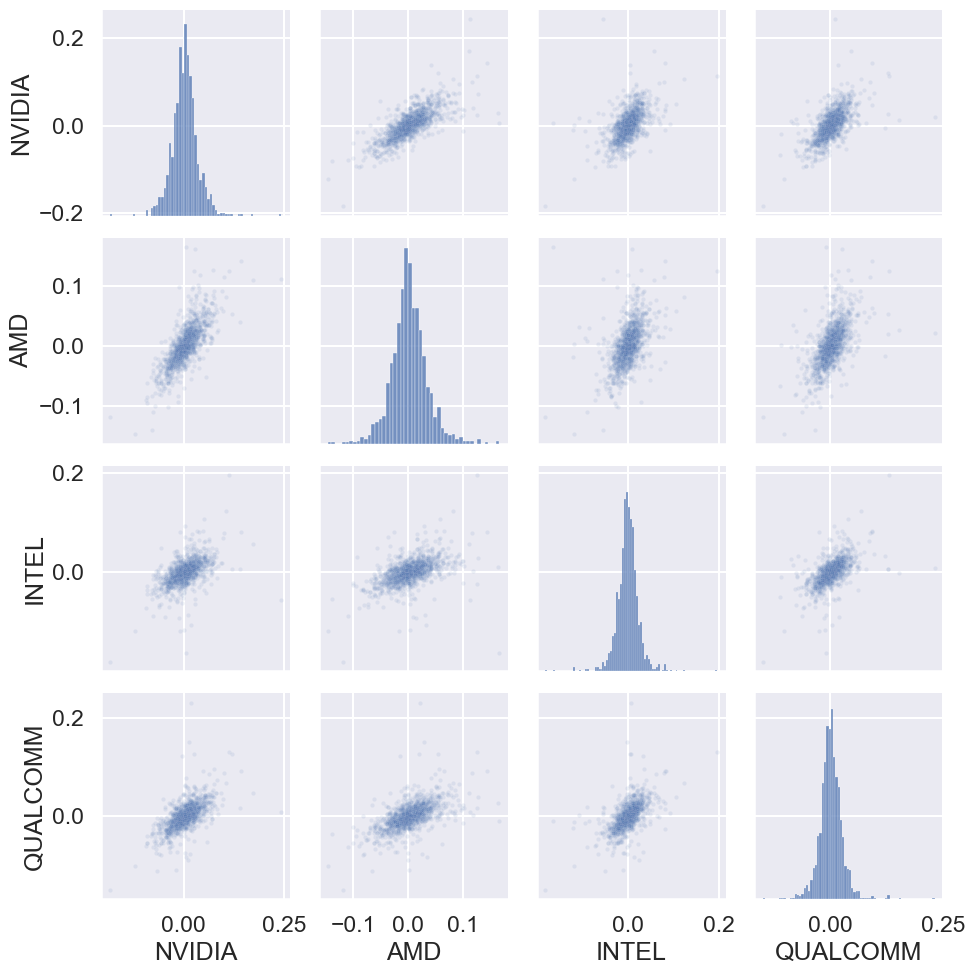

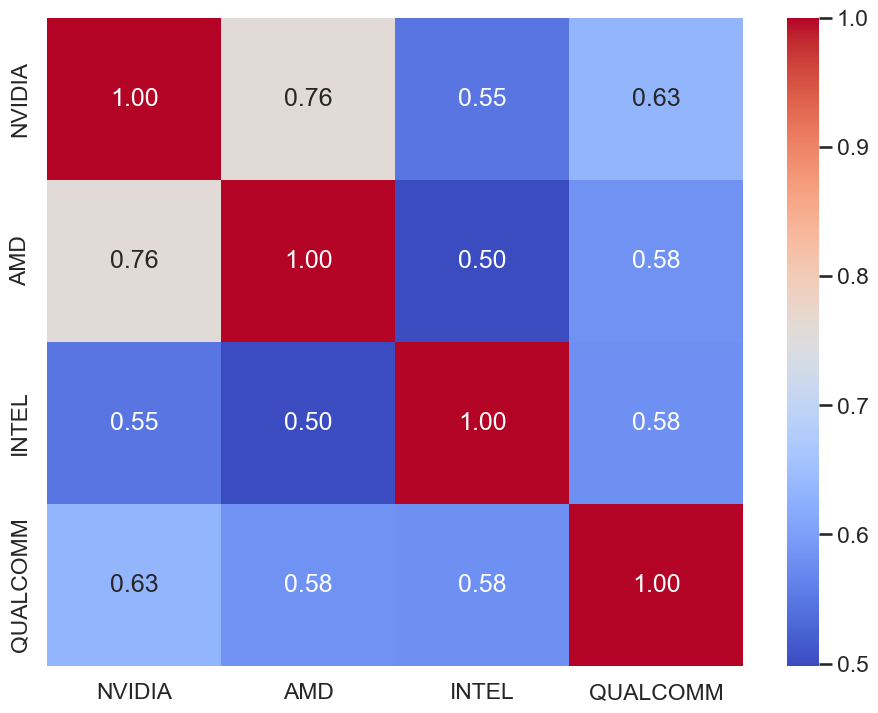

In [9]:
# Select only the 'Adj Close' column for each stock
adj_closes = pd.DataFrame({c_name: c_data['Adj Close'] for c_data, c_name in zip(data_list, c_names)})

# Correlation as PairPlot
tech_rets = adj_closes.pct_change()
sns.set(rc={'figure.figsize':(12,12)})
sns.set_context('talk')
sns.pairplot(tech_rets, kind='scatter', plot_kws={'alpha':0.1, 's':10})
sns.set_palette('deep')
sns.set_style('whitegrid', {'axes.grid' : True})

plt.show()

# Correlation as Heatmap
corr_matrix = tech_rets.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### Risk VS Expected Return

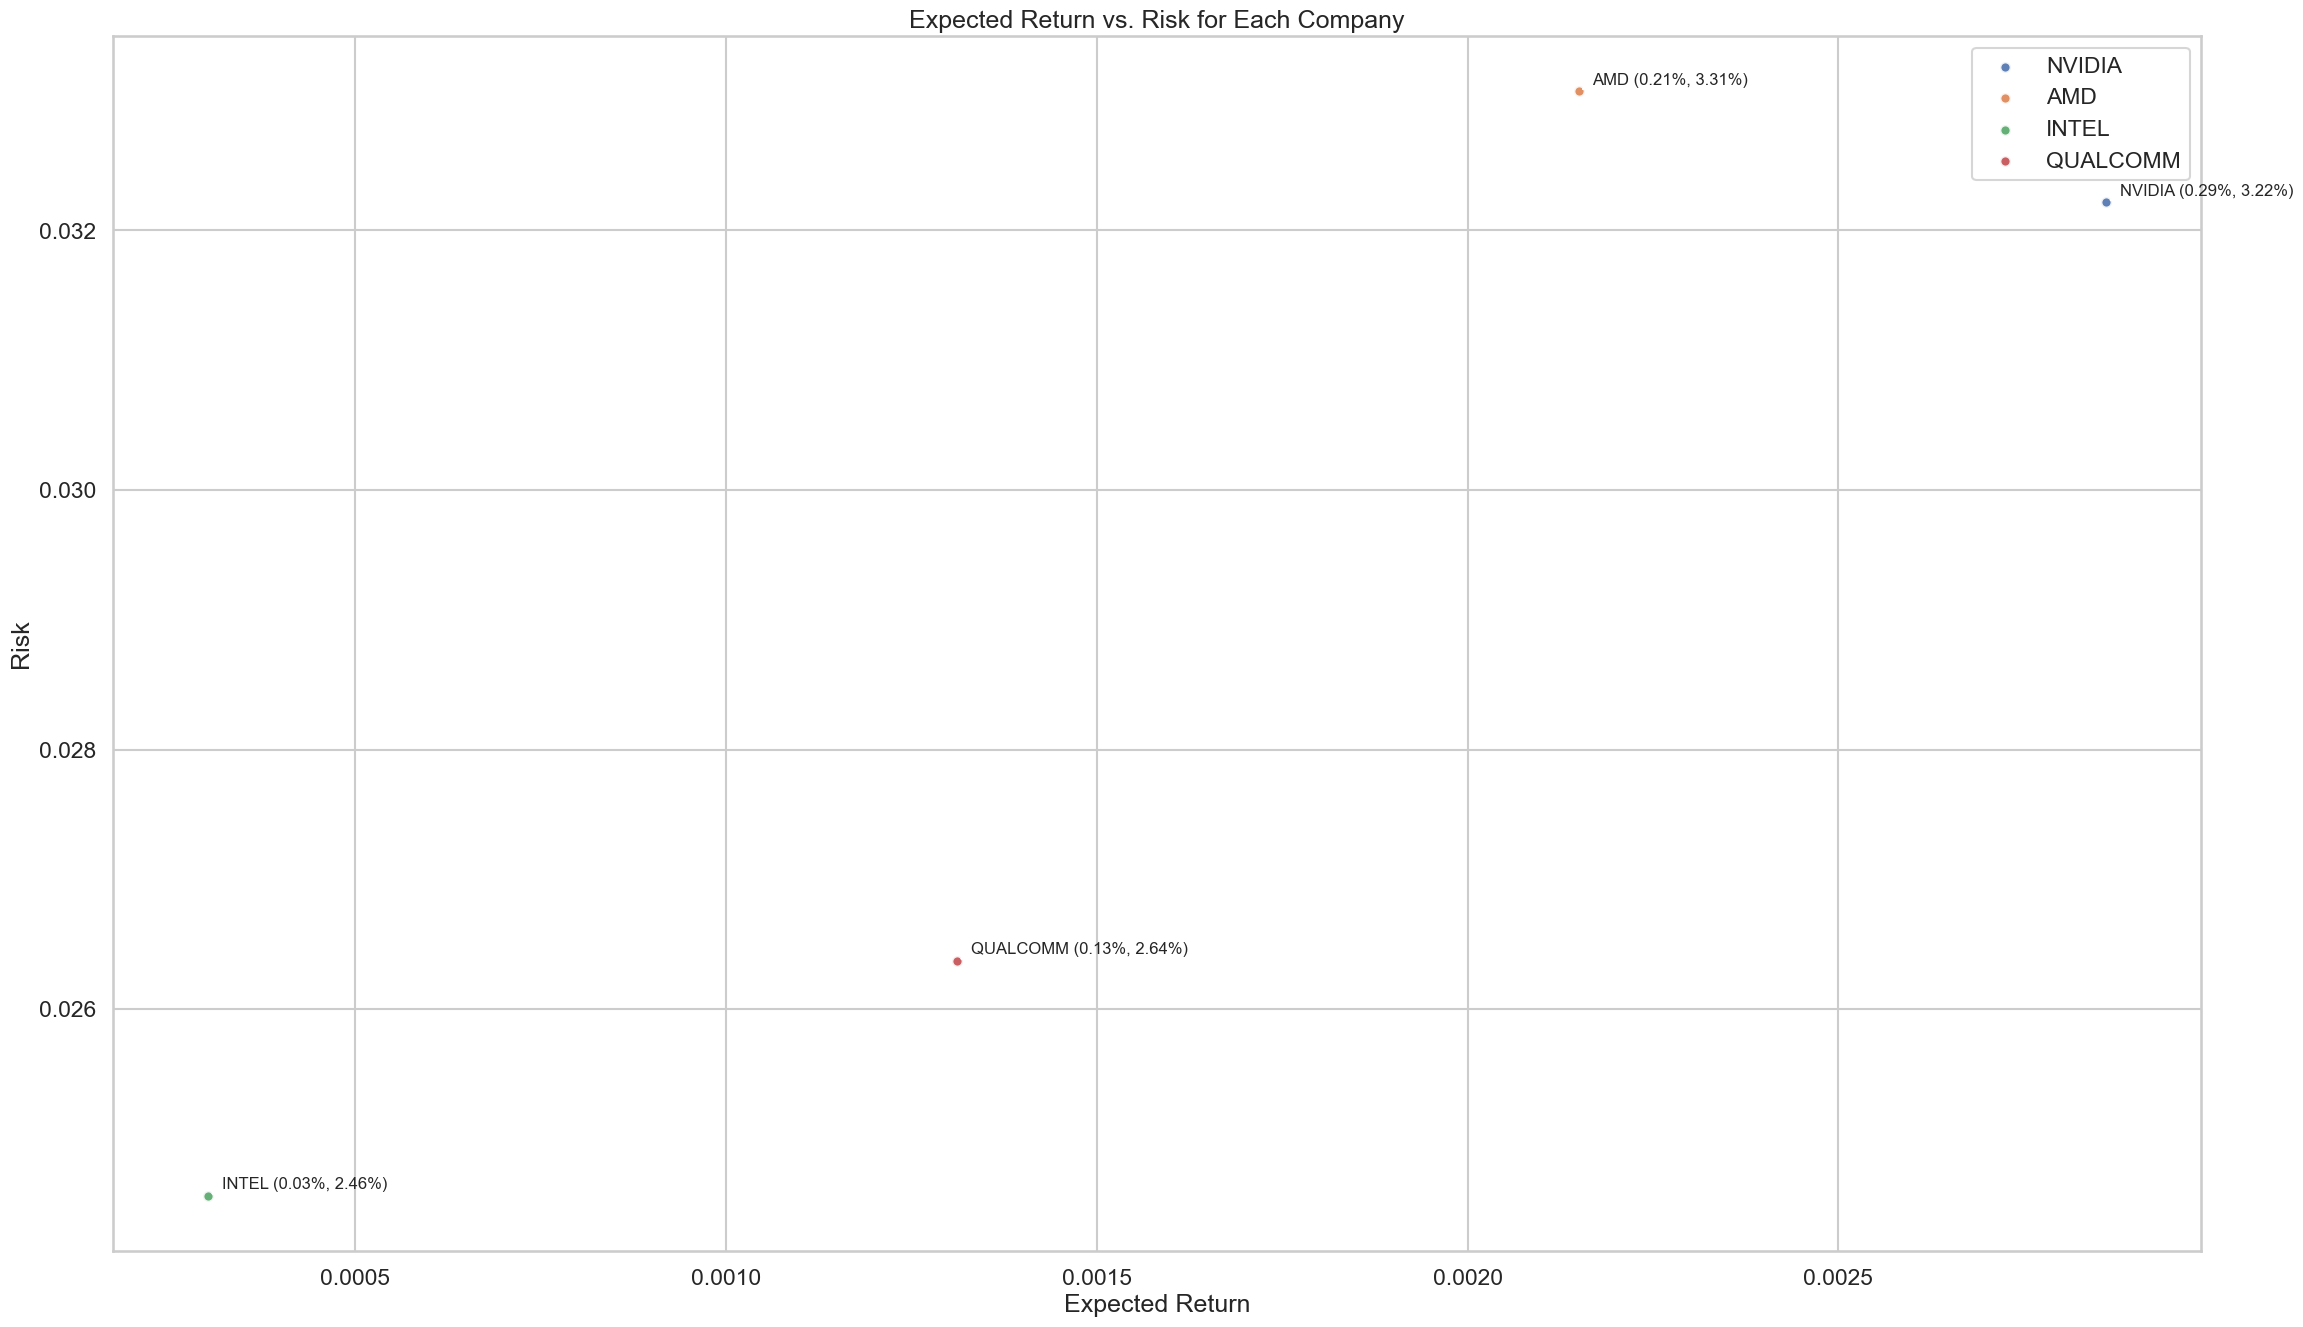

In [13]:
plt.figure(figsize=(24, 15))
area = np.pi * 20

# Iterate over each company name to calculate and plot their expected return and risk
for c_name in c_names:
    # Create a boolean mask for the current company
    mask = data['Company Name'] == c_name
    # Calculate the daily return and store it in a temporary variable instead of modifying the slice directly
    daily_return = data.loc[mask, 'Adj Close'].pct_change()
    # Now you can work with daily_return directly without modifying the original DataFrame
    mean_return = daily_return.mean()
    risk = daily_return.std()
    
    plt.scatter(mean_return, risk, s=area, label=c_name, alpha=0.9, linewidths=2, edgecolors='w')
    
    plt.annotate(f'{c_name} ({mean_return:.2%}, {risk:.2%})', 
                xy=(mean_return, risk), 
                xytext=(10, 5), 
                textcoords='offset points', 
                fontsize=12, 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.title('Expected Return vs. Risk for Each Company')
plt.xlabel('Expected Return')
plt.ylabel('Risk')

plt.legend(loc='upper right')
plt.grid(True)
plt.show()